# CNN with Brain Cell Images

Nicholas Larsen
Steven Larsen

This data came from real world microscopic images.  Each image is a blood smear from a patient that was then placed on a slide for imaging.  This data was collected with the intention of classifing Acute Lymphoblastic Leukemia (ALL).  This can be a difficult task in, due to the differences between healthy and cells with leukemia being extremely small.  Each image from the data set was analyzed by an expert oncologist.  


# Load images, show a few examples

In [1]:
from PIL import Image
from os import listdir
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from skimage.feature import daisy
from sklearn.metrics.pairwise import pairwise_distances
from skimage.io import imshow
from ipywidgets import widgets  # make this interactive!
from ipywidgets import fixed
import copy
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.losses import BinaryCrossentropy
from sklearn.metrics import make_scorer, accuracy_score,precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn import metrics as mt
from copy import deepcopy
from sklearn.preprocessing import StandardScaler

def gray_sacle(data):
    return np.dot(data[...,:3], [0.299, 0.587, 0.114])

def read_images(directories, grey_scale=False, verb = False):
    """Reads in the all and rem directoires under each directory in the list directories"""
    X = []
    y = []
    for direct in dirs:
        if verb:
            print(f"Reading {direct}")
        direct_all = f"{direct}\\all"
        for file in listdir(direct_all):
            if verb:
                print(f"Reading file: {file}")
            image = Image.open(f"{direct_all}\\{file}")
            data = np.asarray(image)
            if grey_scale:
                data = gray_sacle(data)
            #data = data.ravel()
            X.append(data)
            y.append(1)
                
        direct_rem = f"{direct}\\hem"
        for file in listdir(direct_rem):
            if verb:
                print(f"Reading file: {file}")
            image = Image.open(f"{direct_rem}\\{file}")
            data = np.asarray(image)
            if grey_scale:
                data = gray_sacle(data)
            #data = data.ravel()
            X.append(data)
            y.append(0)
                
    return np.asarray(X), np.asarray(y)

def plot_gallery(images, titles, h, w, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.7 * n_col, 2.3 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i],cmap='bone')
    plt.show()

In [2]:
%%time
dirs = [
    r'..\archive\C-NMC_Leukemia\training_data\fold_0',
    r'..\archive\C-NMC_Leukemia\training_data\fold_1',
    r'..\archive\C-NMC_Leukemia\training_data\fold_2'
#    r'..\archive\C-NMC_Leukemia\training_data\fold_small'
]
X, y = read_images(dirs, verb=False)
print(X.shape)

(10655, 450, 450, 3)
Wall time: 2min 8s


In [3]:
y_0 = len(y[y==0])
y_1 = len(y[y==1])
print(len(y[y==0]), len(y[y==1]))
print(y_0/(y_1+y_0))

3383 7272
0.3175035194744252


## Trim images to only have the cell part

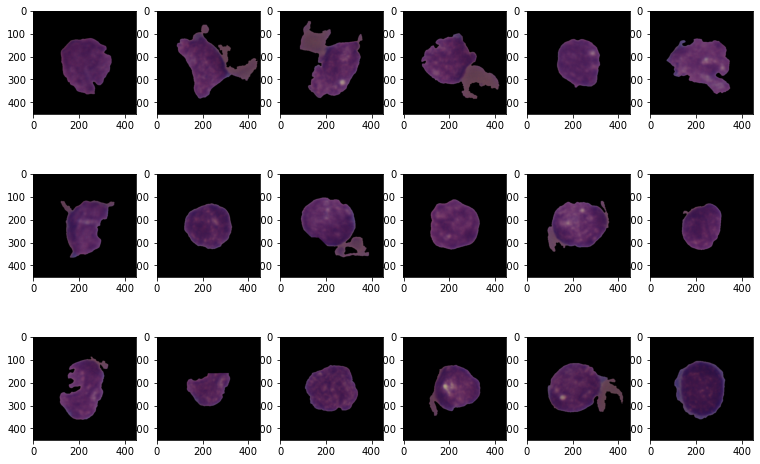

In [4]:
plot_gallery(X, [i for i  in range(0,18)], 450,450)

In [5]:
for idx, x in enumerate(range(7,10)):
    print(idx, x)

0 7
1 8
2 9


In [6]:
def get_img_extremes(img):
    min_row = 0
    max_row = 0

    for i in range(len(img)):
        s = np.sum(img[i])
        if min_row == 0 and s != 0:
            min_row = i
        if min_row != 0 and max_row < s:
            max_row = i

    max_col = 0
    min_col = 0
    for i in range(len(img)):
        s = np.sum(img[:,i])
        if min_col == 0 and s > 0:
            min_col = i
        if min_col != 0 and max_col < s:
            max_col = i
    return [min_row, max_row, min_col, max_col]

min_row = 449
max_row = 0
min_col = 449
max_col = 0
extss = []
for img in X:
    exts = get_img_extremes(img)
    extss.append(exts)
    min_row = min(exts[0] , min_row)
    max_row = max(exts[1] , max_row)
    min_col = min(exts[2] , min_col)
    max_col = max(exts[3] , max_col)

In [7]:
extss = np.array(extss)
min_row = int((np.mean(extss[:,0]) - np.std(extss[:,0])).round())
max_row = int((np.mean(extss[:,1]) + np.std(extss[:,1])).round())
min_col = int((np.mean(extss[:,2]) - np.std(extss[:,2])).round())
max_col = int((np.mean(extss[:,3]) + np.std(extss[:,3])).round())
print('Mean min_row:', min_row)
print('Mean max_row:', max_row)
print('Mean min_col:', min_col)
print('Mean max_col:', max_col)

Mean min_row: 101
Mean max_row: 349
Mean min_col: 100
Mean max_col: 350


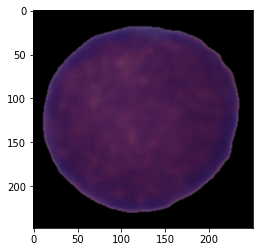

In [8]:
# example cropped image
WIDTH = max_col - min_col
HEIGHT = max_row - min_row
plt.imshow(img[min_row:max_row, min_col:max_col],cmap='bone')

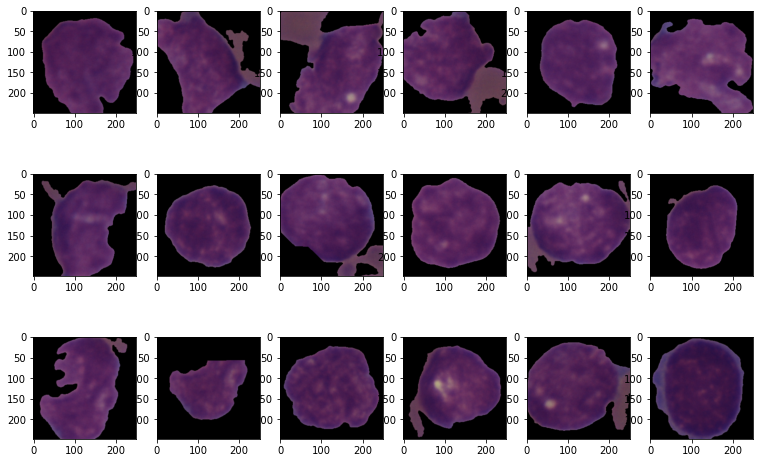

In [9]:
plot_gallery(X[:,min_row:max_row, min_col:max_col], h = HEIGHT, w = WIDTH, titles=[i for i  in range(0,18)])

In [10]:
X = X[:,min_row:max_row, min_col:max_col]

In [11]:
# Randomly cut dataset in half to make it more managable
# ONLY RUN ONCe
#SKIPPED
idxs = [i for i in range(len(X))]
idxs = np.random.choice(idxs, 2000)
X = X[idxs]
y = y[idxs]

y_0 = len(y[y==0])
y_1 = len(y[y==1])
print(len(y[y==0]), len(y[y==1]))
print(y_0/(y_1+y_0))

627 1373
0.3135


# Define splitting Techniques

Our data is going to be split into training and testing (80 / 20).  During development of models we will use this 80/20 split. Then when we want to compare the models we are going to use Stratified testing with 5 folds on the training data only. This is appropriate because in practice this model will be deployed and just used as a screening tool for doctors. We are just trying to minimize the amount of images a doctor has to look at with a certain degree of reliability.

In [12]:
# Split the data
X_train, X_test, y_train, y_test =\
    train_test_split(X, y, test_size=0.2, stratify=y)
X_train.shape

(1600, 248, 250, 3)

## Normalize 

In [13]:
# Normilize the X
#X = X/255.0 - 0.5
#for col in numeric_headers:
#    df_train[col] = df_train[col].astype(np.float)
#    df_test[col] = df_test[col].astype(np.float)
#    
#    ss = StandardScaler()
#    df_train[col] = ss.fit_transform(df_train[col].values.reshape(-1, 1))
#    df_test[col] = ss.transform(df_test[col].values.reshape(-1, 1))

X_train = np.copy(X_train)

for row in range(X_train.shape[1]):
    for col in range(X_train.shape[2]):
        ss = StandardScaler()
        X_train[:,row,col] = ss.fit_transform(X_train[:,row,col])
        X_test[:,row,col] = ss.transform(X_test[:,row,col])

# Preparation
## Explain Metrics

As stated above the goal of our model is to reduce the amount of images a doctor will have to look at. The goal is to hardly ever miss identify a positive  Lymphoblastic Leukemia cell, but reduce the count of cells that might be  Lymphoblastic Leukemia reliably. because of this we are going to focus on the true positive, meaning we will focus on the recall score. We want to have recall score of 97% to have a acceptable model in this area. 

You can see from below there is a slight class imbalance problem but it is about 1/3-2/3 TODO Add graph

In [14]:
NUM_CLASSES = 2

X_train, X_test, y_train, y_test =\
    train_test_split(X, y, test_size=0.2, stratify=y)

y_train_ohe = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test_ohe = keras.utils.to_categorical(y_test, NUM_CLASSES)

(array([125.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 275.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

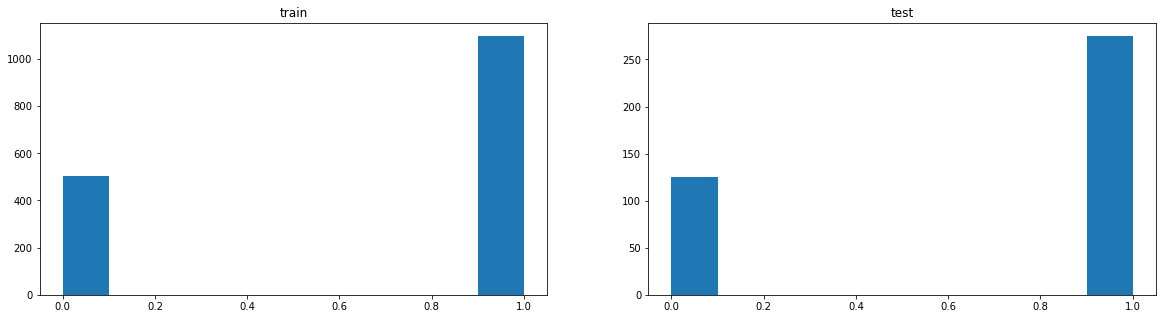

In [27]:
fig = plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
plt.title('train')
plt.hist(y_train)

plt.subplot(1,2,2)
plt.title('test')
plt.hist(y_test)

____

# Modeling

## Set up Data Expansion in Keras. 
### Options from town hall
* Data augmentation he showed an example of. Tends to be slow
* Go through and a couple of passes of expansion'
* Use expansion for a couple of epic at the end
### Reasoning

### Data Augmentation

### Data Augmentation

* Rotation: We are deciding not to perform any rotation on the images since the images are cells the orientations of them is likely to be pretty random and probably has a good distribution of orientations across the many samples the large dataset has. 
* Shifting: we will allow for shifting to prevent the location from of characteristics in the image from being memorized.
* We will allow it to flip either vertically or horizontally
* No scaling or color shifting will be preformed

In [28]:
print(X_train.shape, y_train.shape)

(1600, 248, 250, 3) (1600,)


In [29]:
datagen = None

In [30]:
%%time
datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_epsilon= 0.,
    zca_whitening=False,
    rotation_range=0, # used, Int. Degree range for random rotations.
    width_shift_range=0.1, # used, Float (fraction of total width). Range for random horizontal shifts.
    height_shift_range=0.1, # used,  Float (fraction of total height). Range for random vertical shifts.
    shear_range=0., # Float. Shear Intensity (Shear angle in counter-clockwise direction as radians)
    zoom_range=0.,
    channel_shift_range=0.,
    fill_mode='nearest',
    cval=0.,
    horizontal_flip=True,
    vertical_flip=True,
    rescale=None)

datagen.fit(X_train)


Wall time: 704 ms


In [31]:
print(len(y[y==0]), len(y[y==1]))

627 1373


In [32]:
 print(len(y[y==0])/(len(y[y==1])+len(y[y==0]))*100)

31.35


(1, 248, 250, 3)


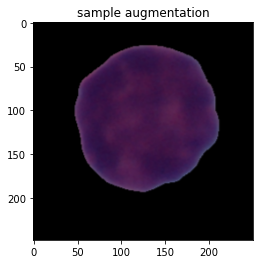

In [33]:
tmps = datagen.flow(X[[1,2]], X[[1,2]], batch_size=1)

for tmp in tmps:
    print(tmp[0].shape)
    plt.imshow(tmp[0].squeeze().astype(np.uint8))
    plt.title("sample augmentation")
    break
    

tmps = None

# This will turn the values into floats, to graph ints are required

## Create Convolutional Neural Network using Keras. 
* Investigate different parameters on at least two different network architectures
* Architectural Differences
 * Number of layers
 * Whether or not using residual paths
 * Seperable convolutions
 
Need a total of 4 models

____

In [34]:
print(X.shape, y.shape)
print(y.reshape(-1,1).shape)

(2000, 248, 250, 3) (2000,)
(2000, 1)


### Model 1.1

In [7]:
%%time
from tensorflow.keras.losses import MeanSquaredLogarithmicError
from sklearn.utils.class_weight import compute_class_weight


NUM_CLASSES = 2
channels = 3
    
def model_1_create(X_train, X_test, y_train, y_test,print_summary=True,
                  use_class_weights=True, num_filt_layers = [16,32], dropouts = [0.25, 0.5]):
    
    X_train = X_train.astype(np.float32)
    X_test = X_test.astype(np.float32)
    
    cnn = Sequential()
    first = True
    num_filt_layers = [16, 32]
    for num_filters in num_filt_layers:
        if first:
            cnn.add( Conv2D(filters=num_filters, 
                            kernel_size=(3,3), 
                            padding='same', 
                            activation='relu',
                            data_format="channels_last",
                            input_shape=(X_train.shape[1],
                                         X_train.shape[2],
                                         X_train.shape[3]))) # more compact syntax
        else:
            cnn.add( Conv2D(filters=num_filters, 
                        kernel_size=(3,3), 
                        padding='same', 
                        activation='relu',
                        data_format="channels_last")) # more compact syntax
        first = False
        
    cnn.add( MaxPooling2D(pool_size=(2, 2), data_format="channels_last") )
    
    # add one layer on flattened output
    cnn.add( Dropout(dropouts[0]) ) # add some dropout for regularization after conv layers
    cnn.add( Flatten() )
    cnn.add( Dense(1024, activation='relu') )
    cnn.add( Dropout(dropouts[1]) ) # add some dropout for regularization, again!
    cnn.add( Dense(NUM_CLASSES, activation='sigmoid') )
    
    # Let's train the model 
    cnn.compile(loss='binary_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
                  optimizer='rmsprop', # 'adadelta' 'rmsprop'
                  metrics=['accuracy'])
    
    cnn.build(X_train.shape)
    if print_summary:
        cnn.summary()
    return cnn
    
def model_1_train(cnn, X_train, X_test, y_train, y_test, epochs=5,
                  use_class_weights = True):

    datagen = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_epsilon= 0.,
        zca_whitening=False,
        rotation_range=0, # used, Int. Degree range for random rotations.
        width_shift_range=0.1, # used, Float (fraction of total width). Range for random horizontal shifts.
        height_shift_range=0.1, # used,  Float (fraction of total height). Range for random vertical shifts.
        shear_range=0., # Float. Shear Intensity (Shear angle in counter-clockwise direction as radians)
        zoom_range=0.,
        channel_shift_range=0.,
        fill_mode='nearest',
        cval=0.,
        horizontal_flip=True,
        vertical_flip=True,
        rescale=None)
    datagen.fit(X)
    
    # https://stackoverflow.com/questions/43481490/keras-class-weights-class-weight-for-one-hot-encoding
    # got wieghts code from here ^
    d_class_weights = None
    if use_class_weights:
        y_integers = np.argmax(y_train, axis=1)
        class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
        d_class_weights = dict(enumerate(class_weights))
    
    #the flow method yields batches of images indefinitely, with the given transformations
    history = cnn.fit_generator(datagen.flow(X_train, y_train, batch_size=128), 
                       steps_per_epoch=int(len(X_train)/128), # how many generators to go through per epoch
                       epochs=epochs, verbose=0, class_weight=d_class_weights,
                       validation_data=(X_test,y_test))
    
    return history, cnn


Wall time: 0 ns


In [30]:
%%time
model_1_nn_x = None

model_1_1 =  model_1_create(X_train, X_test, y_train_ohe, y_test_ohe,
                                 print_summary=False)

history_1_1, model_1_1 = model_1_train(model_1_1_nn_x, X_train, X_test, y_train_ohe, y_test_ohe,
                                             epochs=50)



Wall time: 1h 10min 43s


Text(0.5, 0, 'epochs')

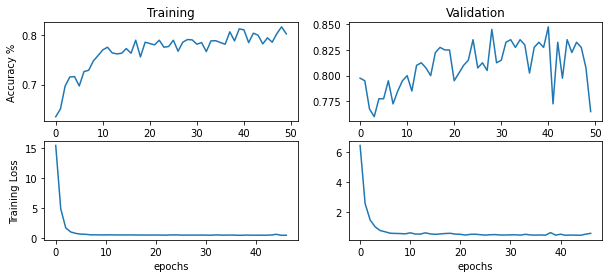

In [31]:
from matplotlib import pyplot as plt

%matplotlib inline

plt.figure(figsize=(10,4))
plt.subplot(2,2,1)
plt.plot(history_1_1.history['accuracy'])

plt.ylabel('Accuracy %')
plt.title('Training')
plt.subplot(2,2,2)

plt.plot(history_1_1.history['val_accuracy'])
plt.title('Validation')

plt.subplot(2,2,3)
plt.plot(history_1_1.history['loss'][3:])
plt.ylabel('Training Loss')
plt.xlabel('epochs')

plt.subplot(2,2,4)
plt.plot(history_1_1.history['val_loss'][3:])
plt.xlabel('epochs')

In [33]:
yhat_per = model_1_1_nn_x.predict(X_test)
yhat = np.round(yhat_per)

In [34]:
print(mt.confusion_matrix(y_test,yhat[:,1].astype(np.uint8)))
print(mt.classification_report(y_test,yhat[:,1].astype(np.uint8)))

[[ 99  22]
 [ 72 207]]
              precision    recall  f1-score   support

           0       0.58      0.82      0.68       121
           1       0.90      0.74      0.81       279

    accuracy                           0.77       400
   macro avg       0.74      0.78      0.75       400
weighted avg       0.81      0.77      0.77       400



In [37]:
model_1_1_nn_x.save('model_1_1_nn.h5')

In [38]:
from tensorflow.keras.models import load_model
test = load_model('model_1_1_nn.h5')

In [39]:
yhat_per = test.predict(X_test)
yhat = np.round(yhat_per)
print(mt.confusion_matrix(y_test,yhat[:,1].astype(np.uint8)))
print(mt.classification_report(y_test,yhat[:,1].astype(np.uint8)))

[[ 99  22]
 [ 72 207]]
              precision    recall  f1-score   support

           0       0.58      0.82      0.68       121
           1       0.90      0.74      0.81       279

    accuracy                           0.77       400
   macro avg       0.74      0.78      0.75       400
weighted avg       0.81      0.77      0.77       400



### Model 1.2

In [42]:
model_1_2_nn =  model_1_create(X_train, X_test, y_train_ohe, y_test_ohe,
                                      use_class_weights = False, num_filt_layers = [8,16,32])



history_1_2, model_1_2_nn = model_1_train(model_1_1_nn_x, X_train, X_test, y_train_ohe, y_test_ohe,
                                             epochs=50)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 248, 250, 16)      448       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 248, 250, 32)      4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 124, 125, 32)      0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 124, 125, 32)      0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 496000)            0         
_________________________________________________________________
dense_8 (Dense)              (None, 1024)              507905024 
_________________________________________________________________
dropout_9 (Dropout)          (None, 1024)             

In [43]:
print(len(y_train[y_train==0]), len(y_train[y_train==1]))

482 1118


In [44]:
np.sum(y_train_ohe[:, 0])

482.0

In [45]:
np.sum(y_train_ohe[:, 1])

1118.0

In [46]:
yhat_per = model_1_2_nn.predict(X_test)
yhat = np.round(yhat_per)

In [47]:
print(mt.confusion_matrix(y_test,yhat[:,1].astype(np.uint8)))
print(mt.classification_report(y_test,yhat[:,1].astype(np.uint8)))

[[ 99  22]
 [ 55 224]]
              precision    recall  f1-score   support

           0       0.64      0.82      0.72       121
           1       0.91      0.80      0.85       279

    accuracy                           0.81       400
   macro avg       0.78      0.81      0.79       400
weighted avg       0.83      0.81      0.81       400



In [48]:
model_1_2_nn.save('model_1_2_nn.h5')
model_1_2_nn.input

<tf.Tensor 'conv2d_4_input:0' shape=(None, 248, 250, 3) dtype=float32>

In [49]:
model_1_2_nn.input_shape

(None, 248, 250, 3)

## Model 2 

In [6]:
%%time
from tensorflow.keras.losses import MeanSquaredLogarithmicError
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.layers import Input, average, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Add, Input
from tensorflow.keras.layers import average, concatenate


NUM_CLASSES = 2
channels = 3
    
def model_2_create(X_train, X_test, y_train, y_test, print_summary=True,
                  dropouts = [0.25, 0.5],
                  filters=(32,32,64), hidden_layers=[512,256]):
    
    X_train = X_train.astype(np.float32)
    X_test = X_test.astype(np.float32)
    
    input_holder = Input(shape=(HEIGHT, WIDTH, 3))

    # start with a conv layer
    x = Conv2D(filters=filters[0],
                   input_shape = (HEIGHT,WIDTH,1),
                   kernel_size=(1,1),
                   kernel_initializer='he_uniform', 
                   padding='same', 
                   activation='relu', data_format="channels_last")(input_holder)
    x = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)
    
    x = Conv2D(filters=filters[1],
                   kernel_size=(3,3),
                   kernel_initializer='he_uniform', 
                   padding='same', 
                   activation='relu', 
                   data_format="channels_last")(x)

    x = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

    x = Conv2D(filters=filters[2],
                   kernel_size=(1,1),
                   kernel_initializer='he_uniform', 
                   padding='same', 
                   activation='relu', 
                   data_format="channels_last")(x)
    
    x_split = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

    x = Conv2D(filters=filters[0],
                   kernel_size=(1,1),
                   kernel_initializer='he_uniform', 
                   padding='same', 
                   activation='relu', 
                   data_format="channels_last")(x_split)
    

    x = Conv2D(filters=filters[1],
                   kernel_size=(3,3),
                   kernel_initializer='he_uniform', 
                   padding='same', 
                   activation='relu', 
                   data_format="channels_last")(x)
    

    x = Conv2D(filters=filters[2],
                   kernel_size=(1,1),
                   kernel_initializer='he_uniform', 
                   padding='same', 
                   activation='relu', 
                   data_format="channels_last")(x)
    
    x = Add()([x, x_split])
    x = Activation("relu")(x)

    x = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

    x = Flatten()(x)
    x = Dropout(0.25)(x)
    x = Dense(hidden_layers[0])(x)
    x = Activation("relu")(x)
    
    x = Dense(hidden_layers[1])(x)
    x = Activation("relu")(x)
    x = Dropout(0.5)(x)
    
    x = Dense(NUM_CLASSES)(x)
    x = Activation('sigmoid')(x)
    
    
    larsnet = Model(inputs=input_holder,outputs=x)
    if print_summary:
        larsnet.summary()
    
    return larsnet
    
def model_2_train(cnn, X_train, X_test, y_train, y_test, epochs=5,
                  dropouts = [0.25, 0.5]):
    
    cnn.compile(loss='binary_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
                optimizer='rmsprop', # 'adadelta' 'rmsprop'
                metrics=['accuracy'])

    
    datagen = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_epsilon= 0.,
        zca_whitening=False,
        rotation_range=0, # used, Int. Degree range for random rotations.
        width_shift_range=0.1, # used, Float (fraction of total width). Range for random horizontal shifts.
        height_shift_range=0.1, # used,  Float (fraction of total height). Range for random vertical shifts.
        shear_range=0., # Float. Shear Intensity (Shear angle in counter-clockwise direction as radians)
        zoom_range=0.,
        channel_shift_range=0.,
        fill_mode='nearest',
        cval=0.,
        horizontal_flip=True,
        vertical_flip=True,
        rescale=None)
    datagen.fit(X)
     #the flow method yields batches of images indefinitely, with the given transofmrations
    history = cnn.fit_generator(datagen.flow(X_train, y_train, batch_size=128), 
                           steps_per_epoch=int(len(X_train)/128), # how many generators to go through per epoch
                           epochs=epochs,
                           validation_data=(X_test,y_test),verbose=0
                          )

    #history = cnn.fit(X_train, y_train_ohe, batch_size=128, 
    #                      epochs=epochs, verbose=1,
    #                      validation_data=(X_test,y_test_ohe)
    #                     )
    #
    return history, cnn

Wall time: 0 ns


### Model 2.1

In [62]:
model_2_1_nn = None
model_2_1_nn =  model_2_create(X_train, X_test, y_train_ohe, y_test_ohe)

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 248, 250, 3) 0                                            
__________________________________________________________________________________________________
conv2d_28 (Conv2D)              (None, 248, 250, 32) 128         input_4[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_17 (MaxPooling2D) (None, 124, 125, 32) 0           conv2d_28[0][0]                  
__________________________________________________________________________________________________
conv2d_29 (Conv2D)              (None, 124, 125, 32) 9248        max_pooling2d_17[0][0]           
_______________________________________________________________________________________

In [63]:
history_2_1, model_2_1 = model_2_train(model_2_1_nn, X_train, X_test, y_train_ohe, y_test_ohe, epochs=50)

In [64]:
yhat_per = model_2_1_nn.predict(X_test)
yhat = np.round(yhat_per)
print(mt.confusion_matrix(y_test,yhat[:,1].astype(np.uint8)))
print(mt.classification_report(y_test,yhat[:,1].astype(np.uint8)))

[[  4 117]
 [  0 279]]
              precision    recall  f1-score   support

           0       1.00      0.03      0.06       121
           1       0.70      1.00      0.83       279

    accuracy                           0.71       400
   macro avg       0.85      0.52      0.45       400
weighted avg       0.79      0.71      0.60       400



Text(0.5, 0, 'epochs')

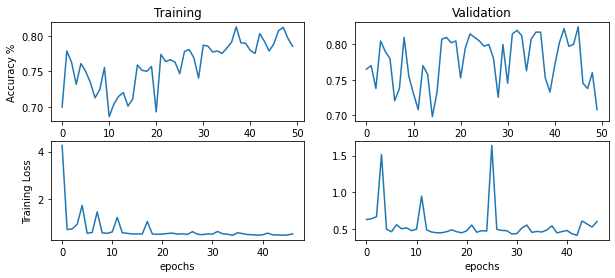

In [65]:
from matplotlib import pyplot as plt

%matplotlib inline

plt.figure(figsize=(10,4))
plt.subplot(2,2,1)
plt.plot(history_2_1.history['accuracy'])

plt.ylabel('Accuracy %')
plt.title('Training')
plt.subplot(2,2,2)

plt.plot(history_2_1.history['val_accuracy'])
plt.title('Validation')

plt.subplot(2,2,3)
plt.plot(history_2_1.history['loss'][3:])
plt.ylabel('Training Loss')
plt.xlabel('epochs')

plt.subplot(2,2,4)
plt.plot(history_2_1.history['val_loss'][3:])
plt.xlabel('epochs')

In [66]:
model_2_1_nn.save('model_2_1_nn.h5')

### Model 2.2

In [67]:
model_2_2_nn = None
model_2_2_nn =  model_2_create(X_train, X_test, y_train_ohe, y_test_ohe,
                              filters=(16,16,32), hidden_layers=[256,128])

Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 248, 250, 3) 0                                            
__________________________________________________________________________________________________
conv2d_34 (Conv2D)              (None, 248, 250, 16) 64          input_5[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_21 (MaxPooling2D) (None, 124, 125, 16) 0           conv2d_34[0][0]                  
__________________________________________________________________________________________________
conv2d_35 (Conv2D)              (None, 124, 125, 16) 2320        max_pooling2d_21[0][0]           
_______________________________________________________________________________________

In [68]:
history_2_2, model2_2 = model_2_train(model_2_1_nn,X_train, X_test, y_train_ohe, y_test_ohe, epochs=50)

In [70]:
yhat_per = model2_2.predict(X_test)
yhat = np.round(yhat_per)
print(mt.confusion_matrix(y_test,yhat[:,1].astype(np.uint8)))
print(mt.classification_report(y_test,yhat[:,1].astype(np.uint8)))

[[ 79  42]
 [ 15 264]]
              precision    recall  f1-score   support

           0       0.84      0.65      0.73       121
           1       0.86      0.95      0.90       279

    accuracy                           0.86       400
   macro avg       0.85      0.80      0.82       400
weighted avg       0.86      0.86      0.85       400



Text(0.5, 0, 'epochs')

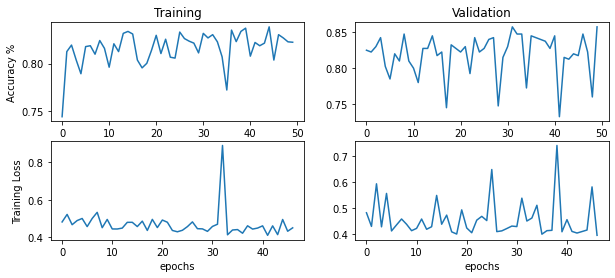

In [73]:
from matplotlib import pyplot as plt

%matplotlib inline

plt.figure(figsize=(10,4))
plt.subplot(2,2,1)
plt.plot(history_2_2.history['accuracy'])

plt.ylabel('Accuracy %')
plt.title('Training')
plt.subplot(2,2,2)

plt.plot(history_2_2.history['val_accuracy'])
plt.title('Validation')

plt.subplot(2,2,3)
plt.plot(history_2_2.history['loss'])
plt.ylabel('Training Loss')
plt.xlabel('epochs')

plt.subplot(2,2,4)
plt.plot(history_2_2.history['val_loss'])
plt.xlabel('epochs')

In [74]:
model_2_2_nn.save('model_2_2_nn.h5')

In [2]:
%%time
# Reload data 
dirs = [
    r'..\archive\C-NMC_Leukemia\training_data\fold_0',
    r'..\archive\C-NMC_Leukemia\training_data\fold_1',
    r'..\archive\C-NMC_Leukemia\training_data\fold_2'
#    r'..\archive\C-NMC_Leukemia\training_data\fold_small'
]
X, y = read_images(dirs, verb=False)
print(X.shape)

(10655, 450, 450, 3)
Wall time: 1min 13s


In [ ]:
X = np.delete(X, idxs, axis=0)
y = np.delete(y, idxs, axis=0)

In [9]:
idxs = [i for i in range(len(X))]
idxs = np.random.choice(idxs, 2000)
X = X[idxs]
y = y[idxs]

## Compare the 4 Models


In [10]:
len(X)

2000

In [11]:
#https://medium.com/@literallywords/stratified-k-fold-with-keras-e57c487b1416
import warnings
warnings.filterwarnings('ignore')
def stratifiedKFoldRuns_1(X_train, y_train,
                        model_create, model_train, K=2, scorer=recall_score, epochs=2,
                        use_class_weights=True, num_filt_layers=[16,32], dropouts=[0.25, 0.5]):
    
    cv = StratifiedKFold(n_splits=K, shuffle=True)
    my_scorer = make_scorer(scorer)

    scores = [] 
    for index, (train_indices, val_indices) in enumerate(cv.split(X_train, y_train)):
        print(f"Training on fold {index+1}/{K}...")

        _X_train = X_train[train_indices]
        _X_test = X_train[val_indices]
        _y_train = y_train[train_indices]
        _y_test = y_train[val_indices]
        

        _y_train_ohe = keras.utils.to_categorical(_y_train, NUM_CLASSES)
        _y_test_ohe = keras.utils.to_categorical(_y_test, NUM_CLASSES)
        
        model = model_create(_X_train, _X_test, _y_train_ohe, _y_test_ohe, print_summary=True,
                            use_class_weights=use_class_weights, num_filt_layers=num_filt_layers,
                            dropouts=dropouts)
        
        _history, model = model_train(model, _X_train, _X_test, _y_train_ohe, _y_test_ohe,
                            epochs=epochs, use_class_weights=use_class_weights)
        
        
        yhat = model.predict(_X_test) 
        yhat = np.round(yhat)
        score = scorer(yhat[:,1],_y_test)
    
        scores.append(score)
        print("Last training score: ",score)
    return scores

def stratifiedKFoldRuns_2(X_train, y_train,
                        model_create, model_train, K=2, scorer=recall_score, epochs=2,
                        dropouts=[0.25, 0.5], filters=(32,32,64), hidden_layers=[512,256]):
    
    cv = StratifiedKFold(n_splits=K, shuffle=True)
    my_scorer = make_scorer(scorer)

    scores = [] 
    for index, (train_indices, val_indices) in enumerate(cv.split(X_train, y_train)):
        print(f"Training on fold {index+1}/{K}...")

        _X_train = X_train[train_indices]
        _X_test = X_train[val_indices]
        _y_train = y_train[train_indices]
        _y_test = y_train[val_indices]
        

        asdf = keras.utils.to_categorical(_y_train, NUM_CLASSES)
        _y_test_ohe = keras.utils.to_categorical(_y_test, NUM_CLASSES)
        
        model = model_create(_X_train, _X_test, asdf, _y_test_ohe, print_summary=False,
                            filters=filters,hidden_layers=hidden_layers,
                            dropouts=dropouts)
        print(asdf.shape)
        _history, model = model_train(model, _X_train, _X_test, asdf, _y_test_ohe, epochs=epochs)
        
        
        yhat = model.predict(_X_test) 
        yhat = np.round(yhat)
        score = scorer(yhat[:,1],_y_test)
    
        scores.append(score)
        print("Last training score: ",score)
    return scores
#def model_1_create(X_train, X_test, y_train, y_test,print_summary=True,
#                  use_class_weights=True, num_filt_layers = [16,32], dropouts = [0.25, 0.5]):
#    
#def model_1_train(cnn, X_train, X_test, y_train, y_test, epochs=5,
#                  use_class_weights = True):



#def model_2_create(X_train, X_test, y_train, y_test,
#                  dropouts = [0.25, 0.5],
#                  filters=(32,32,64), hidden_layers=[512,256]):
#    
#def model_2_train(cnn, X_train, X_test, y_train, y_test, epochs=5,
#                  dropouts = [0.25, 0.5]):

### Model 1.1 on K folds

In [ ]:
%%time
scores_1_1 = stratifiedKFoldRuns_1(X, y, model_1_create, model_1_train,K=5,epochs=1)
scores_1_1

Training on fold 1/5...
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 450, 450, 16)      448       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 450, 450, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 225, 225, 32)      0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 225, 225, 32)      0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1620000)           0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              1658881024
_________________________________________________________________
dropout_3 (Dropout)          (

In [ ]:
scores_1_1 = [0.8523206751054853,
 0.8602620087336245,
 0.900990099009901,
 0.8423236514522822,
 0.8326848249027238]

<BarContainer object of 5 artists>

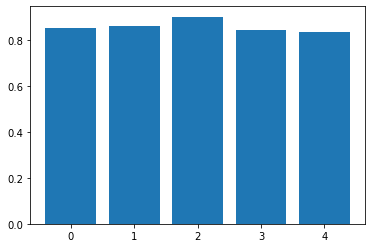

In [45]:

plot_data = np.array(scores_1_1)
plt.bar(x=range(len(plot_data)),height=plot_data)

### Model 1.2 on K Folds 

In [38]:
%%time
scores_1_2 = stratifiedKFoldRuns_1(X_train, y_train, model_1_create, model_1_train,K=5,epochs=50,
                                  use_class_weights=True, num_filt_layers = [16,32], dropouts = [0.25, 0.5])
scores_1_2

Training on fold 1/5...
Instructions for updating:
Please use Model.fit, which supports generators.
Last training score:  0.8915094339622641
Training on fold 2/5...
Last training score:  0.8513513513513513
Training on fold 3/5...
Last training score:  0.9040404040404041
Training on fold 4/5...
Last training score:  0.8796296296296297
Training on fold 5/5...
Last training score:  0.8847926267281107
Wall time: 5h 13min 38s


[0.8915094339622641,
 0.8513513513513513,
 0.9040404040404041,
 0.8796296296296297,
 0.8847926267281107]

<BarContainer object of 5 artists>

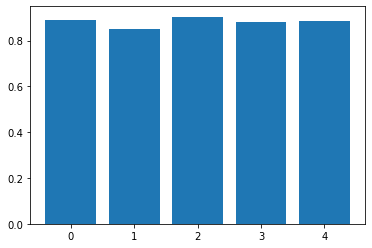

In [46]:
scores_1_2 = [0.8915094339622641,
 0.8513513513513513,
 0.9040404040404041,
 0.8796296296296297,
 0.8847926267281107]
plot_data = np.array(scores_1_2)
plt.bar(x=range(len(plot_data)),height=plot_data)

### Model 2.1 on K Folds

In [ ]:
%%time
scores_2_1 = stratifiedKFoldRuns_2(X_train, y_train, model_2_create, model_2_train,K=5,epochs=50)
scores_2_1
plot_data = np.array(scores_2_1)
plt.bar(x=range(len(plot_data)),height=plot_data)

In [42]:
scores_2_1 = [0.8373015873015873,
 0.8701298701298701,
 0.8125,
 0.8704453441295547,
 0.8801652892561983]
plot_data = np.array(scores_2_2)
plt.bar(x=range(len(plot_data)),height=plot_data)

### Model 2.2 on K Folds 

In [39]:
%%time
scores_2_2 = stratifiedKFoldRuns_2(X_train, y_train, model_2_create, model_2_train,K=5,epochs=50,
                                  dropouts = [0.25, 0.5], filters=(32,32,64), hidden_layers=[512,256])
scores_2_2

Training on fold 1/5...
(1280, 2)
Last training score:  0.7667844522968198
Training on fold 2/5...
(1280, 2)
Last training score:  0.8464730290456431
Training on fold 3/5...
(1280, 2)
Last training score:  0.7773851590106007
Training on fold 4/5...
(1280, 2)
Last training score:  0.851063829787234
Training on fold 5/5...
(1280, 2)
Last training score:  0.8292682926829268
Wall time: 1h 57min 33s


[0.7667844522968198,
 0.8464730290456431,
 0.7773851590106007,
 0.851063829787234,
 0.8292682926829268]

<BarContainer object of 5 artists>

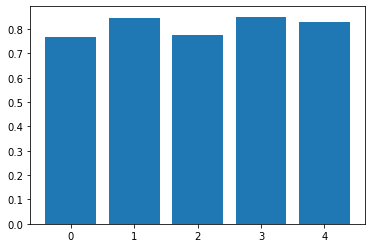

In [44]:
scores_2_2 = [0.7667844522968198,
 0.8464730290456431,
 0.7773851590106007,
 0.851063829787234,
 0.8292682926829268]
plot_data = np.array(scores_2_2)
plt.bar(x=range(len(plot_data)),height=plot_data)

## Run on Standard MLP

## Visualize the final Results
* Visualize
* Compare statistically
* Compare the performance to a standard ML_P using the receiver operating characteristic and the area under the curve
This includes:
* Which one is the best
* Which one you should choose
* How might you deploy it
* All of the things you might be interested in

In [51]:
#Compare 2 models with a 90% confidence 
def compare_scores(scores_1, scores_2):
    
    evals1 = np.asarray(scores_1)
    evals2 = np.asarray(scores_2)
    
    t = 1.383  / np.sqrt(10)
    e = (1-evals1)-(1-evals2)
    stdtot = np.std(e)
    dbar = np.mean(e)
    return dbar-t*stdtot, dbar+t*stdtot

comp = compare_scores(scores_1_1,scores_1_2)
print('1_1 vs 1_2 Range of:', comp[0], comp[1])

comp = compare_scores(scores_1_1,scores_2_1)
print('1_1 vs 2_1 Range of:', comp[0], comp[1])

comp = compare_scores(scores_1_1,scores_2_2)
print('1_1 vs 2_2 Range of:', comp[0], comp[1])

comp = compare_scores(scores_1_2,scores_2_1)
print('1_2 vs 2_1 Range of:', comp[0], comp[1])

comp = compare_scores(scores_1_2,scores_2_2)
print('1_2 vs 2_2 Range of:', comp[0], comp[1])

comp = compare_scores(scores_2_1,scores_2_2)
print('2_1 vs 2_2 Range of:', comp[0], comp[1])

1_1 vs 1_2 Range of: 0.014351134326383921 0.034745740276713344
1_1 vs 2_1 Range of: -0.02424522185885026 0.017029554504127735
1_1 vs 2_2 Range of: -0.06616393520228639 -0.020878663350030503
1_2 vs 2_1 Range of: -0.04544394175535399 -0.010868600202465797
1_2 vs 2_2 Range of: -0.0898080872586709 -0.04633138589674324
2_1 vs 2_2 Range of: -0.04813292721554942 -0.031694003982044944


## Compare to a MLP

In [71]:
probas

array([[0., 1.],
       [1., 0.],
       [0., 1.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]])

on fold 1
on fold 2
on fold 3


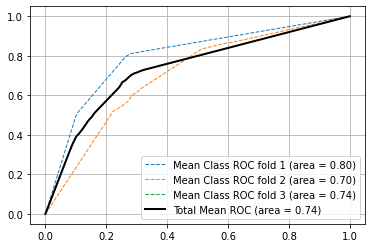

In [72]:
#Our model Area under curve 
from sklearn.metrics import roc_curve, auc
from scipy import interp
from sklearn.model_selection import StratifiedKFold

K = 3


kfold = StratifiedKFold(n_splits=K).split(X_train, y_train)


mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

for i, (train, test) in enumerate(kfold):
    print('on fold', i + 1)
    
    model =  model_1_create(X_train[train], X_train[test], y_train_ohe[train], y_train_ohe[test],
                                 print_summary=False)
    
    history, model = model_1_train(model, X_train[train], X_train[test], y_train_ohe[train], y_train_ohe[test],
                                             epochs=1)
    
    probas = model.predict(X_train[test])
    # turn predict into a proba format


    perclass_mean_tpr = 0.0
    roc_auc = 0
    classes = np.unique(y_train[train])
    # get the mean fpr and tpr, per class
    for j in classes:
        fpr, tpr, thresholds = roc_curve(y_train[test],
                                         probas[:, j],
                                         pos_label=j)
        perclass_mean_tpr += interp(mean_fpr, fpr, tpr)
        perclass_mean_tpr[0] = 0.0
        roc_auc += auc(fpr, tpr)
        
    perclass_mean_tpr /= len(classes)
    roc_auc /= len(classes)
    mean_tpr += perclass_mean_tpr
    plt.plot(mean_fpr,perclass_mean_tpr,'--',lw=1,label='Mean Class ROC fold %d (area = %0.2f)'
                   % (i+1, roc_auc))
    
mean_tpr /= K
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr,perclass_mean_tpr,'k-',lw=2,label='Total Mean ROC (area = %0.2f)'
                   % (mean_auc))
plt.legend(loc='best')
plt.grid()

on fold 1
on fold 2
on fold 3
on fold 4
on fold 5


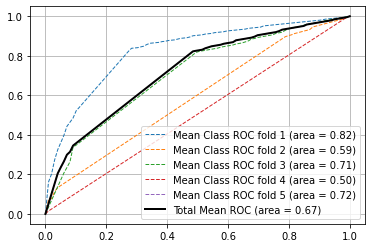

In [77]:
#MLP Area under the curve

from sklearn.metrics import roc_curve, auc
from scipy import interp
from sklearn.neural_network import MLPClassifier
K = 5


kfold = StratifiedKFold(n_splits=K).split(X_train, y_train)

X_train_mlp = X_train.reshape(X_train.shape[0],X_train.shape[1]*X_train.shape[2]*X_train.shape[3])
X_test_mlp = X_test.reshape(X_test.shape[0],X_test.shape[1]*X_test.shape[2]*X_test.shape[3])

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

for i, (train, test) in enumerate(kfold):
    
    print('on fold', i  + 1)
    # model coms out fit from create_model
    clf = MLPClassifier(hidden_layer_sizes=(50, 25, 12), 
                        activation='relu', 
                        solver='adam', 
                        alpha=1e-4, # L2 penalty
                        batch_size=128, # min of 200, num_samples
                        learning_rate='adaptive', # decrease rate if loss goes up
                        #learning_rate_init=0.1, # only SGD
                        #power_t=0.5,    # only SGD with inverse scaling
                        max_iter=5, 
                        shuffle=True, 
                        random_state=1, 
                        tol=1e-9, # for stopping
                        verbose=False, 
                        warm_start=False, 
                        #momentum=0.9, # only SGD
                        #nesterovs_momentum=True, # only SGD
                        early_stopping=False, 
                        validation_fraction=0.1, # only if early_stop is true
                        beta_1=0.9, # adam decay rate of moment
                        beta_2=0.999, # adam decay rate of moment
                        epsilon=1e-08) # adam numerical stabilizer

    clf.fit(X_train_mlp[train],y_train[train])
    probas = clf.predict_proba(X_train_mlp[test])
    perclass_mean_tpr = 0.0
    roc_auc = 0
    classes = np.unique(y_train[train])
    # get the mean fpr and tpr, per class
    for j in classes:
        fpr, tpr, thresholds = roc_curve(y_train[test],
                                         probas[:, j],
                                         pos_label=j)
        perclass_mean_tpr += interp(mean_fpr, fpr, tpr)
        perclass_mean_tpr[0] = 0.0
        roc_auc += auc(fpr, tpr)
        
    perclass_mean_tpr /= len(classes)
    roc_auc /= len(classes)
    mean_tpr += perclass_mean_tpr
    plt.plot(mean_fpr,perclass_mean_tpr,'--',lw=1,label='Mean Class ROC fold %d (area = %0.2f)'
                   % (i+1, roc_auc))
    
mean_tpr /= K
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr,perclass_mean_tpr,'k-',lw=2,label='Total Mean ROC (area = %0.2f)'
                   % (mean_auc))
plt.legend(loc='best')
plt.grid()

# Use transfer learning to pre-train weights of your initial layers of CNN
* Compare to best other model
* There is an exmaple in his notebook. Use Img Net weights, VGG. Compare from scratch from above

In [ ]:
%%time

# manipulated from Keras Documentation
#  https://keras.io/applications/
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np

res_model = ResNet50(weights='imagenet')
res_model.summary()